<a href="https://colab.research.google.com/github/kaspergroenbek98/first-first-year-project/blob/master/project1notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
! git clone https://github.com/kaspergroenbek98/first-first-year-project.git
### All import calls.
import numpy as np
import nltk
import csv
import re
from collections import Counter
import pandas as pd
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import seaborn as sn
import matplotlib.pyplot as plt
nltk.download('stopwords')

fatal: destination path 'first-first-year-project' already exists and is not an empty directory.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
### Functions

### START OF VOCABULARY ###
def generate_vocabulary(data, featureData, vocabType): #featureData = data.gender
    '''
    Returns a list/vocabulary of len <= "size" based on the vocabType and the featureColumn specified
    '''
    size = 2000
    # Only get large groups to get representative data
    major_features = nltk.FreqDist(featureData).most_common(5)
    major_masks = [featureData == f for (f, cnt) in major_features]
    fqs = [nltk.FreqDist(word for line in data.text[mask] for word in line.split()) for mask in major_masks]
    return list(vocabType(data, featureData, major_features, major_masks, fqs, size))

def vocab_most_common(data, featureData, major_features, major_masks, fqs, size):
    '''
    Returns a vocabulary checklist for each tweet to check off (True/False).
    Prioritises the most common words for each feature
    '''
    vocabulary = set()
    # get the most common words in each freq dist. zip(*...) removes the counts from fd, and updates vocabulary ONLY with the words
    for fd in fqs:
        vocabulary.update(list(zip(*fd.most_common(size//len(major_features))))[0])
    return vocabulary

def vocab_unique(data, fCol, major_features, major_masks, fqs, size):
    '''
    Returns a vocabulary checklist for each tweet to check off (True/False).
    Prioritises words which are uncommon in other features, but common in one feature
    '''
    major_mask = np.array(np.array(major_masks).sum(axis=0), dtype='bool')
    fq = nltk.FreqDist(word for line in data.text[major_mask] for word in line.split()) # Get a fq for ALL words in the major categories
    words = [word for (word, cnt) in fq.items() if cnt >= 20] # removes rarely mentioned words which probably arent indicative of a significant trend
    priorityArray = []
    for i, word in enumerate(words):
        priorityArray.append([word])
        #divide frequency of word in that state by the tweetcount from that state, and by how often that word is used in total by all states
        score = max(fqs[fID][word]/(int(major_features[fID][1])*fq[word]) for fID in range(len(major_masks)))
        priorityArray[i].append(score)
    priorityArray.sort(key = lambda x: x[1], reverse=True) # Sort them based on their best score
    vocabulary = list(zip(*priorityArray[:size]))[0] # Removes their scores
    return vocabulary

### END OF VOCABULARY ###

def cleaner(text):
    stemmer = nltk.SnowballStemmer("english", ignore_stopwords=True)
    text = text.lower() #All lowercase
    text = re.sub(r'@[A-Za-z0-9]+','',text)
    text = re.sub('https?://[A-Za-z0-9./]+','', text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub('b4', 'before', text)
    text = re.sub(r"amp", " and ", text)
    text = re.sub('resolution', '', text)
    text = re.sub('rt', '', text)
    text = re.sub('years', '', text)
    text = re.sub('new', '', text)
    text = re.sub('year', '', text)
    text = text.strip(' ')
    text = ''.join(char for char in text if char.isalpha() or char == ' ')
    text = ''.join(stemmer.stem(text)) #Stem the words using SnowballStemmer
    return text

In [16]:
"""
Using pandas to load the data file into a CSV.
ISO-8859-1 is the encoding for tweets.
"""
df = pd.read_csv("first-first-year-project/data.csv", encoding = "ISO-8859-1")
#First step to cleaning the data, removing the categories we dont need.
data = df.drop(["other_topic","resolution_topics", "tweet_coord", "tweet_created","tweet_id", "name", "retweet_count", "tweet_date", "user_timezone"], axis = 1)
for i in range(len(data.text)): #Cleaning all the text in our data with our newly build cleaner() function.
  data.text[i] = cleaner(data.text[i])

data.text[1]

'finally master pa of kitchen sink'

In [17]:
# Vectorize using sklearn based on a vocabulary
featureData = data.tweet_state ### CHANGE FEATURE HERE ###
vectorizer = CountVectorizer(analyzer="word", stop_words= "english", min_df = 20, binary= True, vocabulary = generate_vocabulary(data, featureData, vocab_unique))
categories = list(zip(*nltk.FreqDist(featureData).most_common(5)))[0]
mask = np.sum([featureData == category for category in categories], axis = 0, dtype='bool')

# This is required to fix bugs. KFold uses indeces in the length of the array, but pandas "hides" arrays instead of removing them. Reset_index fixes this
featureData = featureData[mask].reset_index()
featureData.drop(["index"], axis = 1)
featureData = featureData.tweet_state ### CHANGE FEATURE HERE ###

#Here we use term frequency to downscale the importance of words occuring many times in a tweet. That way we hopefully get more weighted words. 
tfidf_transformer = TfidfTransformer()
features = vectorizer.fit_transform(data.text[mask])
tfidf_features = tfidf_transformer.fit_transform(features)



from sklearn.model_selection import KFold
# Store an object of the KFold class in a variable with shuffle=True
k= 10
kf = KFold(n_splits=k, shuffle=True)
# """ 
# Loop for the models and their designated folds (1 to k)
# and calculate the average of each of the 'k' models' accuracy
# using the NB classifier and k-fold model class.
# """
results = []
count = 0 # sum to calculate average of model accuracies
bigram_count = 0 # sum to calculate average of bigram model accuracies
for i, (train, test) in enumerate(kf.split(features)): # Loop over K chunk of data splits
    #Accuracy using term frequency. (Odd that its lower, but we do have a small data set)
    NBmodel = MultinomialNB().fit(tfidf_features[train], featureData[train])
    predicted = NBmodel.predict(tfidf_features[test])
    accuracy = np.mean(predicted == featureData[test])
    count += accuracy
    results.append(metrics.precision_recall_fscore_support(featureData[test], predicted))
    # A classification_report
    print("Iteration no.", i, "\n")
    print("Accuracy of iteration number", i, ":", accuracy)
    print("Report based on unigrams and bigrams.")
    print(metrics.classification_report(featureData[test], predicted))
    print("\n\n")

average = count/k

print("The accuracy average of the K-fold model: ", average)


Iteration no. 0 

Accuracy of iteration number 0 : 0.36574074074074076
Report based on unigrams and bigrams.
              precision    recall  f1-score   support

          CA       0.37      0.94      0.53        77
          FL       0.00      0.00      0.00        18
          IL       0.00      0.00      0.00        20
          NY       0.35      0.12      0.18        59
          TX       0.00      0.00      0.00        42

    accuracy                           0.37       216
   macro avg       0.14      0.21      0.14       216
weighted avg       0.23      0.37      0.24       216




Iteration no. 1 

Accuracy of iteration number 1 : 0.3425925925925926
Report based on unigrams and bigrams.
              precision    recall  f1-score   support

          CA       0.35      0.86      0.50        77
          FL       0.00      0.00      0.00        42
          IL       0.00      0.00      0.00        16
          NY       0.26      0.17      0.21        41
          TX       1

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classificat

In [18]:
print('array1: precision, array2: recall, array3: fbetascore, array4: support')
print(list(np.array(results).mean(axis=0).round(2)))
NBmodel.classes_

array1: precision, array2: recall, array3: fbetascore, array4: support
[array([0.35, 0.  , 0.  , 0.29, 0.39]), array([0.88, 0.  , 0.  , 0.13, 0.02]), array([0.49, 0.  , 0.  , 0.17, 0.03]), array([74.1, 25.8, 21.1, 54.3, 40.1])]


array(['CA', 'FL', 'IL', 'NY', 'TX'], dtype='<U2')

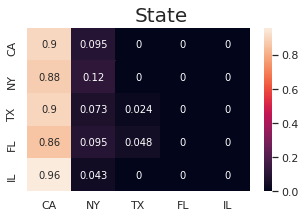

In [19]:
# A perfect confusion matrix using seaborn.
array = metrics.confusion_matrix(featureData[test], predicted, normalize='true', labels = categories)
fig = plt.figure(figsize=(5,3))
fig.suptitle("State", fontsize= 20)
sn.set(font_scale=1) # for x/y label size
sn.heatmap(array, annot=True, annot_kws={"size": 10}, xticklabels = categories, yticklabels = categories) # annot_kws is the size of the numbers.
plt.show()

In [20]:
def print_top10(vectorizer, NBmodel): # Found on stackoverflow
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(NBmodel.classes_):
        top10 = np.argsort(NBmodel.coef_[i])[-10:]
        print("%s: %s" % (class_label,
              " ".join(feature_names[j] for j in top10)))
        
print_top10(vectorizer, NBmodel)

CA: let happy going love want time sta like make stop
FL: money going want time happy stop sta day people make
IL: eat day let love fuck stop time like happy make
NY: like better time going good happy people make eat stop
TX: eat know sta let try like time better make stop
